__This book shows the integration of AS data for variant impact prediction in a linear model.__

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
sys.path.append("../")
import preproc as preproc
import train as train
import analysis as ana

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [2]:
# Same as Firnberg et al., 2014
AA_PROPERTY = {
    "W": "Aromatic",
    "F": "Aromatic",
    "Y": "Aromatic",
    "P": "Aliphatic",
    "M": "Aliphatic",
    "I": "Aliphatic",
    "L": "Aliphatic",
    "V": "Aliphatic",
    "A": "Aliphatic",
    "G": "Aliphatic",
    "C": "Polar uncharged",
    "S": "Polar uncharged",
    "T": "Polar uncharged",
    "Q": "Polar uncharged",
    "N": "Polar uncharged",
    "D": "Neg. charged",
    "E": "Neg. charged",
    "H": "Pos. charged",
    "R": "Pos. charged",
    "K": "Pos. charged",
}

# Protein property features (alanine scanning feature is not included).
DEMASK_FEATURES = ['entropy', 'log2f_var', 'matrix']

# Data reading

DMS and AS data were normalised as mentioned in the Method that:
* Contain only single amino acid (alanine) substitution compared to the reference protein sequence
* score to 1 for wildtype-like variants
* score to 0 for nonsense-like variants

The `dataset_info` file contains the experimental information of DMS and AS data.

In [ ]:
"""# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/normalized_dms_DeMaSk_features.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/normalized_alanine_scanning.csv')

data_info = pd.read_csv('../data/data_info/dataset_info.csv', index_col=0)"""

In [3]:
# Normalized DMS data and DeMaSk features. Keep 'NA' in wt_mut.
norm_dms = pd.read_csv('../data/normalized/dms_DeMaSk_features_221024.csv', 
                       index_col=0, na_values=[''], keep_default_na=False)
norm_as = pd.read_csv('../data/normalized/as_data_221024.csv')

data_info = pd.read_csv('../data/data_info/dms_as_info_221024.csv', index_col=0)

In [107]:
"""rm_dms = ['urn:mavedb:00000061-a-1', 'urn:mavedb:00000061-b-1', 'urn:mavedb:00000061-c-1', 
          'urn:mavedb:00000061-d-1', 'urn:mavedb:00000061-e-1', 'urn:mavedb:00000061-f-1']
norm_dms = norm_dms.query("dms_id not in @rm_dms")
data_info.loc[data_info.query("Ascan_id == 'raf1_kd_lowionic'").index, 'assumed_compatibility'] = 'High'
data_info = data_info.query("dms_id not in @rm_dms")"""

# Modelling

In [4]:
def preproc_demask_dmsas_data(input_data):
    """Impute, encode and weight DMS+AS data.
    """
    preproc_data = input_data.copy()
    preproc_data = preproc.impute_missing_value(preproc_data, None, ['AS_score'])
    # Encode wild-type & variant type amino acid with AS scores.
    preproc_data, encoded_col = preproc.encode_categorical_feature(preproc_data, ['aa1', 'aa2'], ['aa1', 'aa2'])
    preproc_data[encoded_col] = preproc_data[encoded_col].mul(preproc_data['AS_score'], axis='index')
    # Weight each variant.
    preproc_data = train.add_training_weight(preproc_data)
    return preproc_data, encoded_col


def model_linear_predictor_lopo(input_data, output_dir, encoded_col):
    """Run leave-one-protein-out cross-validation on (filtered) DMS/AS data.
    """
    # LOPO CV
    for unip in input_data['uniprot_id'].unique():
        train_data = input_data.query("uniprot_id != @unip")
        test_data_ori = input_data.query("uniprot_id == @unip")
        train_data, test_data_ori = train.refit_matrix_score(train_data, test_data_ori)

        for model in ['with_as', 'no_as']:
            output_header = f"{output_dir}{unip}_{model}_"
            if model == 'with_as':
                model_features = DEMASK_FEATURES + encoded_col + ['AS_score']
            else:
                model_features = DEMASK_FEATURES.copy()

            estimator = LinearRegression(n_jobs=1)
            predictor = estimator.fit(train_data[model_features], train_data['score'], train_data['weight'])
            test_data = test_data_ori.copy()
            test_data['pred_score'] = predictor.predict(test_data[model_features])
            test_data[["dmsa_id", "position", "aa2", "score", "pred_score"]].to_csv(f"{output_header}prediction.csv")
    return

## Model with all alanine scanning (AS) data

In this experiment, DMS and all AS data are merged by their target proteins.

Missing AS scores were imputed. The AS data are also encoded by wild-type and variant type amino acids by one-hot-encoding.

Variant entries were weighted as the inverse of the number of available measurements.

In [5]:
all_as = norm_as.copy()
# Merge in a cartesian product way.
dms_all_as = pd.merge(norm_dms, all_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

dms_all_as, encoded_col = preproc_demask_dmsas_data(dms_all_as)

The following code run the leave-one-protein-out cross-validation on DMS+AS data.
1. Data from each protein target in the DMS+AS data are picked as testing data.
2. The rest data were used for training.
3. Predictor using or not using AS data (together with encoded columns) are trained and taken for prediction.

In [6]:
model_linear_predictor_lopo(dms_all_as, '../result/prediction/linear_as/all_as/', encoded_col)

## Model with assay compatibility filtered AS subset

### High compatible only

In this experiment, DMS data are matched with AS data of __high__ assay compatibility for modelling.

In [18]:
# Pick AS subset that are highly compatibility with given DMS assay.

# And matching DMS IDs.
comp_as_id = data_info.query("assumed_compatibility == 'High'")[['dms_id', 'Ascan_id']]
comp_as = pd.merge(norm_as, comp_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_comp_as = pd.merge(norm_dms, comp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_comp_as['dmsa_id'] = dms_comp_as['dms_id'] + '@' + dms_comp_as['Ascan_id'].astype(str)
dms_comp_as['Ascan_score_avail'] = ~dms_comp_as['AS_score'].isna()

dms_comp_as, encoded_col = preproc_demask_dmsas_data(dms_comp_as)

In [8]:
model_linear_predictor_lopo(dms_comp_as, '../result/prediction/linear_as/compatible_as/', encoded_col)

### High and medium compatible

In this experiment, DMS data are matched with AS data of __high & medium__ assay compatibility for modelling.

In [19]:
# Pick AS subset that are highly compatibility with given DMS assay.

# And matching DMS IDs.
hmcomp_as_id = data_info.query("assumed_compatibility in ['High', 'Medium']")[['dms_id', 'Ascan_id']]
hmcomp_as = pd.merge(norm_as, hmcomp_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_hmcomp_as = pd.merge(norm_dms, hmcomp_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_hmcomp_as['dmsa_id'] = dms_hmcomp_as['dms_id'] + '@' + dms_hmcomp_as['Ascan_id'].astype(str)
dms_hmcomp_as['Ascan_score_avail'] = ~dms_hmcomp_as['AS_score'].isna()

dms_hmcomp_as, encoded_col = preproc_demask_dmsas_data(dms_hmcomp_as)

In [10]:
model_linear_predictor_lopo(dms_hmcomp_as, '../result/prediction/linear_as/high+med_as/', encoded_col)

## Model with score correlation matched AS subset

In this experiment, DMS data are matched with AS data of __highest score correlation__ for modelling.
1. Spearman correlations between each pair of AS & DMS data were calculated by the AS score and DMS score of alanine substitutions.
2. The correlation values were regularized by the number of alanine substitutions (see Methods). The results were saved in `data_info.regularized_correlation`
3. For each DMS experiment, AS data of highest regularized correlation is picked to be used as modelling feature.

In [20]:
# Pick AS data with highest regularized correlation for DMS study.

corr_as_id = []
for index, df in data_info.groupby('dms_id', as_index=False):
    df = df.sort_values(['regularized_correlation', 'n_ala', 'Ascan_id'])
    if len(df) > 0:
        corr_as_id.append(df.iloc[-1][['dms_id', 'Ascan_id']])  # Pick data with largest regularized correlation.
# And matching DMS IDs.
corr_as_id = pd.DataFrame(corr_as_id)
corr_as = pd.merge(norm_as, corr_as_id, on='Ascan_id', how='outer')
# Merge in a cartesian product way.
dms_corr_as = pd.merge(norm_dms, corr_as[['dms_id', 'u_pos', 'Ascan_id', 'AS_score']],
                       on=['dms_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_corr_as['dmsa_id'] = dms_corr_as['dms_id'] + '@' + dms_corr_as['Ascan_id'].astype(str)
dms_corr_as['Ascan_score_avail'] = ~dms_corr_as['AS_score'].isna()

dms_corr_as, encoded_col = preproc_demask_dmsas_data(dms_corr_as)

In [67]:
model_linear_predictor_lopo(dms_corr_as, '../result/prediction/linear_as/correlate_as/', encoded_col)

# Performance

## Read results

__In this section, we read the prediction result from the previous modelling approaches and evaluate the models performance by prediction correlation for each DMS/AS dataset.__

While reading the prediction result:
1. We iterate over the model using _all AS data_, _AS data of high assay compatibility_ and _AS data filtered by score correlation_.
2. The prediction result using AS data or not (control) were merged together for comparison.

In [6]:
def read_lopo_prediction_result(result_dir, target_proteins):
    """Read leave-one-protein-out cross-validation results for using AS data or not.
    """
    results = dict()
    for model in ['with_as', 'no_as']:
        results[model] = pd.concat([pd.read_csv(f"{result_dir}{unip}_{model}_prediction.csv", index_col=0) 
                                    for unip in target_proteins])
    pred_merge = pd.merge(results['with_as'], results['no_as'], on=["dmsa_id", "position", "aa2", "score"],
                          validate="1:1", suffixes=["_ala", "_noala"], how='outer')
    return pred_merge

In [10]:
file_dir = {'All AS data': '../result/prediction/linear_as/all_as/',
            'Compatibility filtered': '../result/prediction/linear_as/compatible_as/',
            'Correlation matched': '../result/prediction/linear_as/correlate_as/'}
target_proteins = norm_dms['uniprot_id'].unique()

# Read prediction results.
mut_prediction = dict()
for model in file_dir.keys():
    pred_merge = read_lopo_prediction_result(file_dir[model], target_proteins)
    mut_prediction[model] = pred_merge

While evaluating the prediction performance:
1. We evaluate the performance by calculating the Spearman's ρ between the experimental score (`score`) and prediction result (`pred_score_ala` or `pred_score_noala`).
2. This calculation was done for each pair of DMS/AS data, identified by `dmsa_id`.
3. Performance change is calculated from the correlation change for prediction result using AS data or not.

In [11]:
# Evaluate performance with Spearman's ρ on each DMS/AS pair.
model_perform = []
for model in mut_prediction.keys():
    perf_with_as = ana.subgroup_spearmanr(mut_prediction[model], 'dmsa_id', 'score', 'pred_score_ala')
    perf_no_as = ana.subgroup_spearmanr(mut_prediction[model], 'dmsa_id', 'score', 'pred_score_noala')
    perf_merge = pd.merge(perf_with_as, perf_no_as[['rho']], left_index=True, right_index=True, validate="1:1", 
                          suffixes=["_ala", "_noala"], how='outer')
    perf_merge['model'] = model
    model_perform.append(perf_merge)
model_perform = pd.concat(model_perform)

# Post process.
model_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
model_perform['diff_spear'] = model_perform['With AS'] - model_perform['No AS']
model_perform = pd.merge(model_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

In [12]:
if_one_residue = dms_all_as.groupby('dmsa_id')['u_pos'].nunique()
one_residue_filter = if_one_residue[if_one_residue == 1].index

## Models performance

The following code show the performance change (measured by the difference of prediction correlation while using AS data or not) for each modelling result, creating __Figure 5__.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/core/indexes/base.py:2897: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


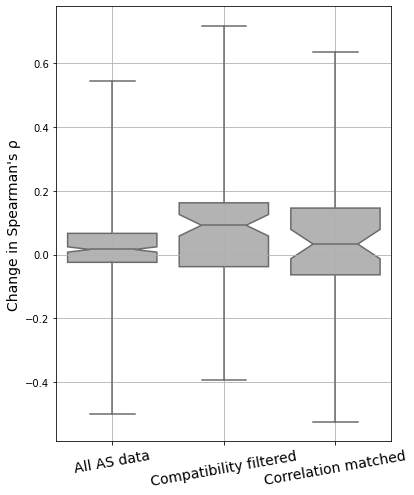

In [13]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

In [75]:
model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter").groupby('model').median()

,With AS,size,No AS,diff_spear,offset,n_ala,ala_score_correlation,regularized_correlation
model,,,,,,,,
All AS data,0.250353,152.0,0.217126,0.016171,0.0,8.0,0.200393,0.179468
Compatibility filtered,0.447936,131.0,0.379326,0.092124,0.0,7.0,0.500000,0.333333
Correlation filtered,0.455188,150.0,0.402562,0.033137,1.0,7.0,0.699301,0.333333


The following code show the prediction correlation for each modelling result, creating __Figure S4__.

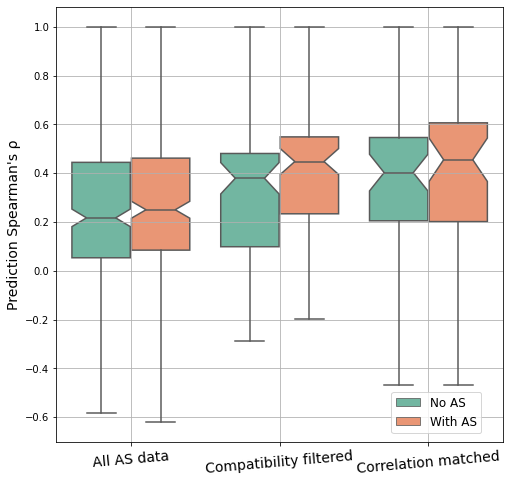

In [15]:
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = model_perform[~model_perform['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                         var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=5)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

## Compatibility filtering details

### Individual DMS/AS pair

The following code show the performance change for each DMS/AS pair while modelled with compatibility filtered AS data, creating __Figure 6__.
1. We started with calculating the Spearman's ρ between each DMS and AS score, becoming the values for horizon axis.
2. The values for vertical axis are the performance change by using AS data.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


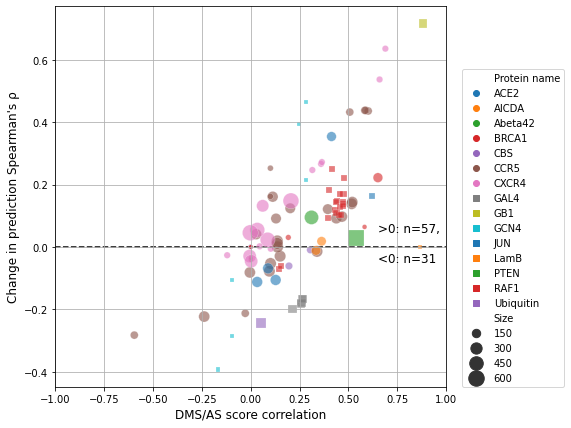

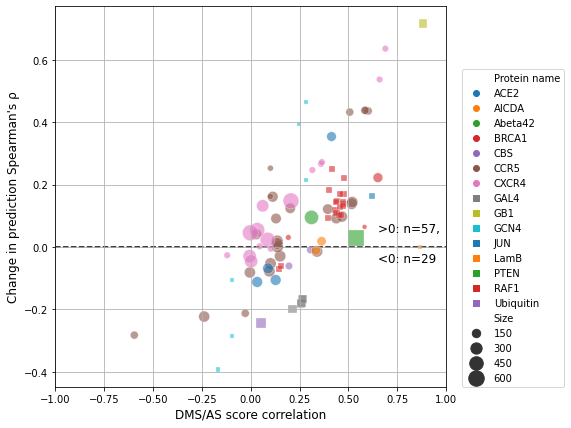

In [16]:
def foo_scatter(work_data):
    """Visualize performance change by using AS data against DMS/AS score correlation.
    """
    # Set markers.
    order = np.sort(work_data['Protein name'].unique())
    half = int(len(order)/2)
    markers = dict(zip(order, ['o']*half + ['s']*(len(order) - half)))

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_spear', size='Size', hue='Protein name', 
                        hue_order=order, style='Protein name', alpha=0.6, ax=ax, sizes=(15,250), 
                        palette="tab10", markers=markers)
    ax.hlines(0, *[-1, 1], linestyles='--', colors='k', zorder=0)  # Baseline.
    ax.text(0.65, -0.05, f">0: n={sum(work_data['diff_spear']>0)},\n\n<0: n={sum(work_data['diff_spear']<0)}", 
            fontsize=12)
    ax.set_xlabel('DMS/AS score correlation', fontsize=12)
    ax.set_ylabel('Change in prediction Spearman\'s ρ', fontsize=12)
    ax.set_xlim(-1, 1)
    ax.legend(loc=(1.04, 0))
    ax.grid()
    plt.show()

    
# Calculate DMS/AS score correlatioin.
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    # Remove variants data with no AS score available.
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# NA value happens when all AS scores are the same, which are then imputed to 0.
dmsa_corr = dmsa_corr.fillna(0)

work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True, 
                     validate='m:1')
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size'}, inplace=True)
foo_scatter(work_data.query("model == 'Compatibility filtered'"))
foo_scatter(work_data.query("model == 'Compatibility filtered' & dmsa_id not in @one_residue_filter"),)

### Individual amino acid type

The following code show the prediction performance for either each wild-type or variant type amino acid while modelling with compatibility filtered AS data, creating __Figure 7__.
1. Instead of evaluating on each DMS/AS data pair, the prediction results are grouped by either wild-type (`aa1`) or variant type amino acid (`aa2`) to calculate the prediction correlation (function: `foo_aa_type_spear`).
2. The performance is visualized by the correlation of using AS data against the correlation for the control result.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


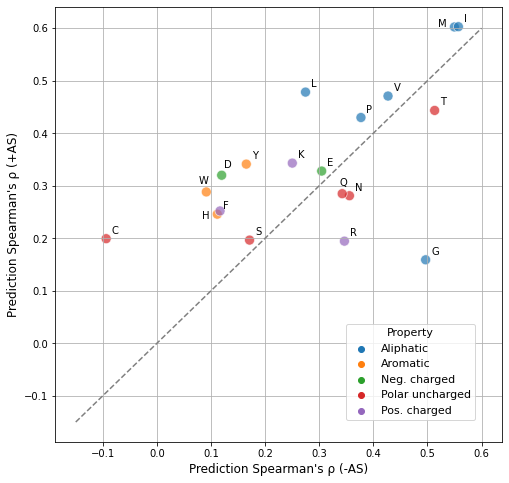

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


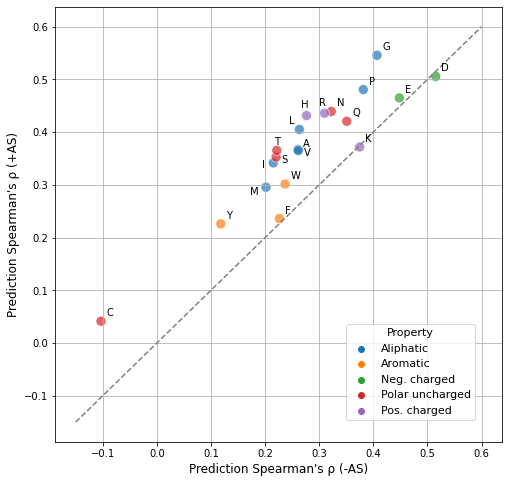

In [50]:
def foo_aa_type_spear(input_data, aa_type):
    """Calculate prediction correlation for each amino acid type.
    """
    # Remove data with no AS scores available.
    work_data = input_data[input_data['dmsa_id'].str[-4:] != '@nan']
    
    # Calculate prediction correlation.
    columns = ['pred_score_ala', 'pred_score_noala']
    foo = ana.subgroup_spearmanr(work_data, aa_type, 'score', 'pred_score_ala')[['rho']]
    foo.columns = ['pred_score_ala']
    bar = ana.subgroup_spearmanr(work_data, aa_type, 'score', 'pred_score_noala')[['rho']]
    bar.columns = ['pred_score_noala']
    aa_perf = pd.concat([foo, bar], axis=1)
    
    # Postprocess.
    aa_perf['aa'] = aa_perf.index
    aa_perf["Property"] = aa_perf["aa"].map(AA_PROPERTY)
    aa_perf['diff'] = aa_perf['pred_score_ala'] - aa_perf['pred_score_noala']
    return aa_perf.sort_values('Property')


def foo_scatter(vis_data, text_shift=dict()):
    """Visualize prediction performance for using AS data or not on each amino acid type.
    """
    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot('pred_score_noala', 'pred_score_ala', data=vis_data, hue='Property', palette='tab10', 
                        s=100, alpha=0.7, ax=ax)
    ax.plot([-0.15,0.6],[-0.15,0.6], '--', color='gray')  # Baseline.
    # Amino acid labels.
    for index, row in vis_data.iterrows():
        aa = row['aa']
        x_shift = text_shift.get(aa,[0.01,0.01])[0]
        y_shift = text_shift.get(aa,[0.01,0.01])[1]
        ax.text(row['pred_score_noala']+x_shift, row['pred_score_ala']+y_shift, aa)
    ax.legend(loc=[.65,0.05], fontsize=11).set_title('Property', prop={'size': 11})
    ax.set_ylabel("Prediction Spearman's ρ (+AS)", fontsize=12)
    ax.set_xlabel("Prediction Spearman's ρ (-AS)", fontsize=12)
    ax.grid()
    plt.show()
    

# Adding wild-type amino acid info.
work_data = pd.merge(mut_prediction['Compatibility filtered'], dms_all_as[['dmsa_id', 'position', 'aa2', 'aa1']], 
                     how='left', on=['dmsa_id', 'position', 'aa2'], validate='m:1')
# Calculate prediction correlation for each amino acid type.
wt_perf = foo_aa_type_spear(work_data, 'aa1')
mt_perf = foo_aa_type_spear(work_data, 'aa2')
foo_scatter(wt_perf, {'Q':[-0.005,0.015], 'W':[-0.015,0.015], 'M': [-0.03, 0], 'H': [-0.0325, -0.015],
                      'D':[0.005,0.015]})
foo_scatter(mt_perf, {'M':[-0.03,-0.015], 'A':[0.01,0.005], 'T':[-0.005,0.01], 'H':[-0.01,0.015],
                      'R':[-0.01,0.015], 'L':[-0.02,0.01], 'I': [-0.02,-0.01],
                      'S':[0.01,-0.01], 'V': [0.01,-0.01]})

In [15]:
wt_perf.sort_values('diff')

,pred_score_ala,pred_score_noala,aa,Property,diff
G,0.158937,0.496637,G,Aliphatic,-0.337700
R,0.194483,0.346558,R,Pos. charged,-0.152076
N,0.280988,0.355842,N,Polar uncharged,-0.074853
T,0.443401,0.513303,T,Polar uncharged,-0.069902
Q,0.284872,0.342457,Q,Polar uncharged,-0.057586
E,0.327968,0.304518,E,Neg. charged,0.023449
S,0.196487,0.171234,S,Polar uncharged,0.025252
V,0.470827,0.427115,V,Aliphatic,0.043712
I,0.602882,0.557169,I,Aliphatic,0.045713
M,0.602363,0.549841,M,Aliphatic,0.052522


In [16]:
mt_perf.sort_values('diff')

,pred_score_ala,pred_score_noala,aa,Property,diff
D,0.505568,0.515262,D,Neg. charged,-0.009695
K,0.371696,0.374776,K,Pos. charged,-0.003080
F,0.235997,0.226283,F,Aromatic,0.009713
E,0.464931,0.448125,E,Neg. charged,0.016806
W,0.301502,0.236820,W,Aromatic,0.064681
Q,0.420548,0.350953,Q,Polar uncharged,0.069595
M,0.295402,0.201576,M,Aliphatic,0.093826
P,0.480678,0.381496,P,Aliphatic,0.099182
V,0.364990,0.261278,V,Aliphatic,0.103712
A,0.367134,0.260694,A,Aliphatic,0.106440


In [17]:
mt_perf.median()

pred_score_ala      0.369415
pred_score_noala    0.262296
diff                0.107171
dtype: float64

In [18]:
mt_perf.query("Property=='Aliphatic'").median()

pred_score_ala      0.367134
pred_score_noala    0.261278
diff                0.106440
dtype: float64

In [19]:
mt_perf.query("Property!='Aliphatic'").median()

pred_score_ala      0.371696
pred_score_noala    0.276556
diff                0.107902
dtype: float64

### ROC plot

The following code show the ROC curve while modelling with compatibility filtered AS data, creating __Figure S10__.

The purpose of this plot is to investigate the potential ability of the prediction result to distinguish wildtype-like and loss-of-function-like variants. Since the classification of these variants varies according to the targets and assays, we alternatively set a series of threshold to test the overall ability of our predictors to discriminate between higher-scored and lower-scored variants.

To do this:
1. A series of scores is set from -0.1 to 0.85.
2. One score is chose at a time to be used as the `threshold` discriminating higher-scored and lower-scored DMS variants.
3. ROC curve for prediction result using or not using AS data are plotted.
4. Step 2 & 3 are iterated over all threshold scores.

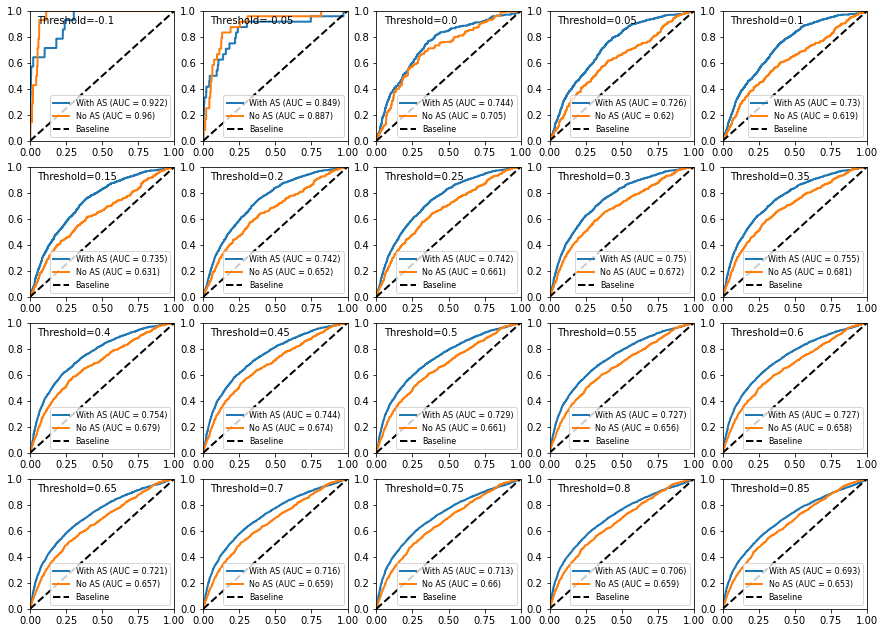

In [31]:
work_data = mut_prediction['Compatibility filtered'].copy()
# Remove data with no AS scores available.
work_data = work_data[work_data['dmsa_id'].str[-4:] != '@nan']

fig, axs = plt.subplots(4, 5, figsize=(15, 11))
fig.patch.set_facecolor('w')
axs = axs.reshape(-1)

label_map = {'pred_score_ala': 'With AS', 'pred_score_noala': 'No AS'}
for i, threshold in enumerate(np.arange(-0.1, 0.9, 0.05)):
    threshold = np.round(threshold, 2)
    if_loss = work_data['score'] <= threshold
    # Iterate over prediction results with and without AS data.
    for result in ['pred_score_ala', 'pred_score_noala']:
        score_loss = -work_data[result]
        ana.plot_roc_curve_on_axes(axs[i], label_map[result], if_loss, score_loss)
    axs[i].plot([0, 1], [0, 1], color="k", lw=2, linestyle="--", label="Baseline")
    axs[i].text(0.05, 0.9, f"Threshold={threshold}")
    axs[i].legend(loc="lower right", fontsize=8)
plt.show()

## Other results

### Data statistics

The following results show the number of proteins, experiments & variant counts for each overall and filtered result, __with available AS data__.

In [21]:
stat_data = dict(zip(['All AS data', 'Compatibility filtered', 'High+medium compatibility', 'Correlation matched'],
                     [dms_all_as,dms_comp_as,dms_hmcomp_as,dms_corr_as]))

for name, data in stat_data.items():
    avail_data = data[data['Ascan_score_avail']]
    print(name)
    print('Available proteins:', len(avail_data.uniprot_id.unique()))
    print('Available DMS experiments:', len(avail_data.dms_id.unique()))
    print('Available AS experiments:', len(avail_data.Ascan_id.unique()))
    print('Available variant entries:', len(avail_data))
    print('*'*80)

All AS data
Available proteins: 22
Available DMS experiments: 54
Available AS experiments: 146
Available variant entries: 70446
********************************************************************************
Compatibility filtered
Available proteins: 15
Available DMS experiments: 35
Available AS experiments: 60
Available variant entries: 15739
********************************************************************************
High+medium compatibility
Available proteins: 21
Available DMS experiments: 51
Available AS experiments: 105
Available variant entries: 28380
********************************************************************************
Correlation matched
Available proteins: 22
Available DMS experiments: 54
Available AS experiments: 32
Available variant entries: 7940
********************************************************************************


### Performance on variants without (filtered) AS data

The following code show the performance change for variants with no (filtered) AS data available, creating __Figure S11__.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/core/indexes/base.py:2897: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


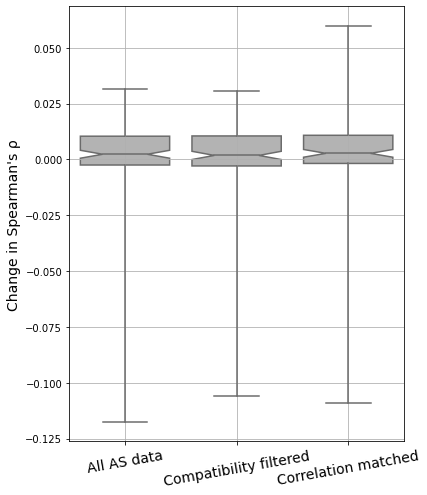

In [22]:
# Keep data with no AS score available.
vis_data = model_perform[model_perform['Ascan_id'].isna()]

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=10)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

The following code show the prediction correlation for variants with no (filtered) AS data available.

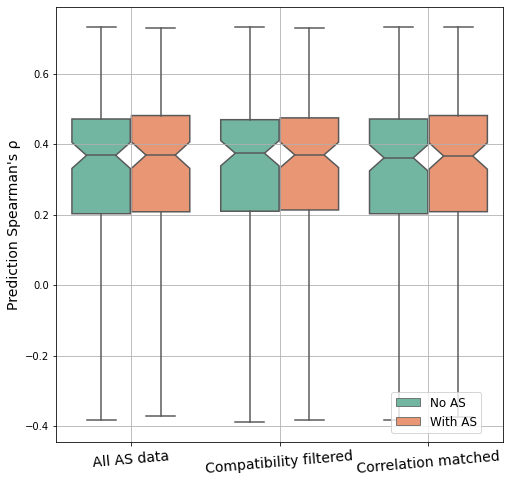

In [24]:
vis_data = model_perform[model_perform['Ascan_id'].isna()]
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                           var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=5)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

### High+medium compatibility performance

The following code read and evaluate the prediction result for modelling with AS data of both high and __medium__ assay compatibility.

The performance is then compared together with previously shown results of modelling with _all AS data_ and _AS data of high assay compatibility_ alone, creating __Figure S5__.

In [34]:
# Read and evaluate results.
hmcomp_prediction = read_lopo_prediction_result('../result/prediction/linear_as/high+med_as/', 
                                                norm_dms['uniprot_id'].unique())
hmcomp_perform = dict()
for pred_col in ['pred_score_ala', 'pred_score_noala']:
    hmcomp_perform[pred_col] = ana.subgroup_spearmanr(hmcomp_prediction, 'dmsa_id', 'score', pred_col)
hmcomp_perform = pd.merge(hmcomp_perform['pred_score_ala'], hmcomp_perform['pred_score_noala'][['rho']], 
                          left_index=True, right_index=True, validate="1:1", suffixes=["_ala", "_noala"], 
                          how='outer')
hmcomp_perform['model'] = 'High+medium\ncompatibility'

# Post process.
hmcomp_perform.rename(columns={'rho_ala': 'With AS', 'rho_noala': 'No AS'}, inplace=True)
hmcomp_perform['diff_spear'] = hmcomp_perform['With AS'] - hmcomp_perform['No AS']
hmcomp_perform = pd.merge(hmcomp_perform, data_info, left_index=True, right_on='dmsa_id', how='left', validate='m:1')

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/pandas/core/indexes/base.py:2897: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


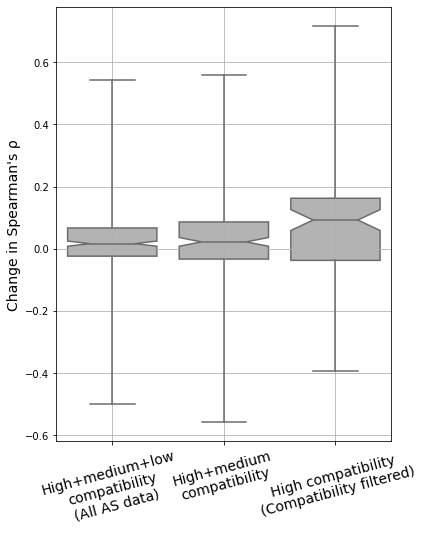

In [35]:
prev_results = model_perform.query("model in ['All AS data', 'Compatibility filtered']")
prev_results = prev_results.replace({'All AS data': 'High+medium+low\ncompatibility\n(All AS data)',
                                     'Compatibility filtered': 'High compatibility\n(Compatibility filtered)'})
vis_data = pd.concat([hmcomp_perform, prev_results])
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = vis_data[~vis_data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")

fig, ax = plt.subplots(1,1,figsize=(6, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='diff_spear', color=(0.7,)*3, notch=True, whis=np.inf,
            order=['High+medium+low\ncompatibility\n(All AS data)', 'High+medium\ncompatibility', 
                   'High compatibility\n(Compatibility filtered)'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=15)
ax.set_ylabel('Change in Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.grid()
plt.show()

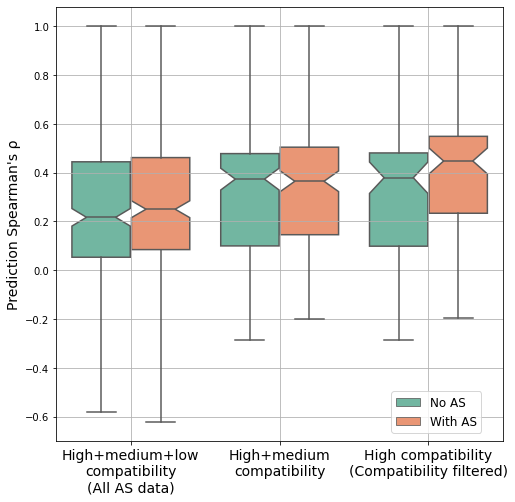

In [36]:
prev_results = model_perform.query("model in ['All AS data', 'Compatibility filtered']")
prev_results = prev_results.replace({'All AS data': 'High+medium+low\ncompatibility\n(All AS data)',
                                     'Compatibility filtered': 'High compatibility\n(Compatibility filtered)'})
vis_data = pd.concat([hmcomp_perform, prev_results])
# Remove data that no or only one one residue has (filtered) AS score.
vis_data = vis_data[~vis_data['Ascan_id'].isna()].query("dmsa_id not in @one_residue_filter")
vis_data = vis_data.melt(id_vars=['dmsa_id', 'model'], value_vars=['No AS', 'With AS'], 
                         var_name='Feature', value_name='spear')

fig, ax = plt.subplots(1,1,figsize=(8, 8))
fig.patch.set_facecolor('w')
sns.boxplot(data=vis_data, x='model', y='spear', hue='Feature', palette='Set2', notch=True, whis=np.inf,
            order=['High+medium+low\ncompatibility\n(All AS data)', 'High+medium\ncompatibility', 
                   'High compatibility\n(Compatibility filtered)'])
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
ax.set_ylabel('Prediction Spearman\'s ρ', fontsize=14)
ax.set_xlabel('')
ax.legend(loc=[0.75,0.02], fontsize=12)
ax.grid()
plt.show()

### Detail of all AS data result

The following code show the performance change for each DMS/AS pair while modelled with __all AS data__, creating __Figure S6__.
1. We started with calculating the Spearman's ρ between each DMS and AS score, becoming the values for horizon axis.
2. The values for vertical axis are the performance change by using AS data.

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


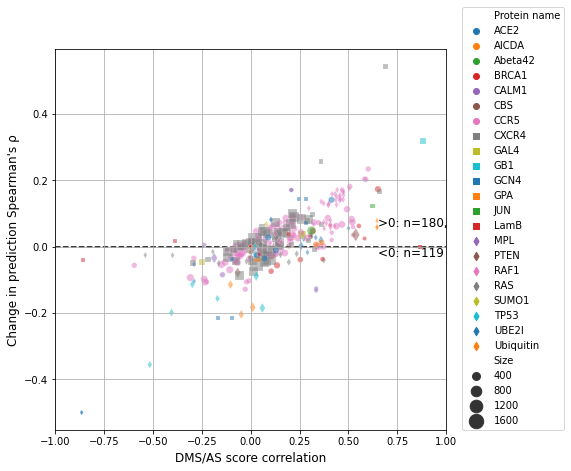

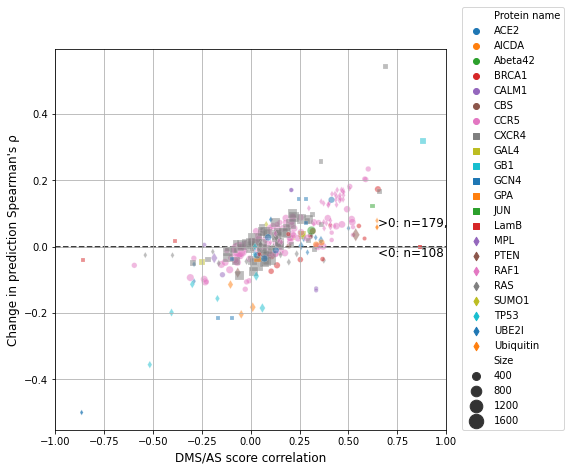

In [25]:
def foo_scatter(work_data):
    """Visualize performance change by using AS data against DMS/AS score correlation.
    """
    # Set markers.
    order = np.sort(work_data['Protein name'].unique())
    third = int(len(order)/3)
    markers = dict(zip(order, ['o']*third + ['s']*third + ['d']*(len(order) - third*2)))

    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    fig.patch.set_facecolor('w')
    g = sns.scatterplot(data=work_data, x='dmsa_corr', y='diff_spear', size='Size', hue='Protein name', 
                        hue_order=order, style='Protein name', alpha=0.5, ax=ax, sizes=(15,250), 
                        palette="tab10", 
                        markers=markers)
    ax.hlines(0, *[-1, 1], linestyles='--', colors='k', zorder=0)  # Baseline.
    ax.text(0.65, -0.03, f">0: n={sum(work_data['diff_spear']>0)},\n\n<0: n={sum(work_data['diff_spear']<0)}", 
            fontsize=12)
    ax.set_xlabel('DMS/AS score correlation', fontsize=12)
    ax.set_ylabel('Change in prediction Spearman\'s ρ', fontsize=12)
    ax.set_xlim(-1, 1)
    ax.legend(loc=(1.04, 0))
    ax.grid()
    plt.show()

    
# Calculate DMS/AS score correlatioin.
dmsa_corr = pd.Series(name='dmsa_corr')
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    # Remove variants data with no AS score available.
    if dmsa[-3:] == 'nan':
        continue
    else:
        dmsa_corr[dmsa] = spearmanr(df['score'], df['AS_score'])[0]
# NA value happens when all AS scores are the same, which are then imputed to 0.
dmsa_corr = dmsa_corr.fillna(0)

work_data = pd.merge(model_perform, dmsa_corr, how='inner', left_on='dmsa_id', right_index=True, 
                     validate='m:1')
work_data.rename(columns={'protein_name':'Protein name', 'size':'Size'}, inplace=True)
foo_scatter(work_data.query("model == 'All AS data'"))
foo_scatter(work_data.query("model == 'All AS data' & dmsa_id not in @one_residue_filter"),)